![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [16]:
import warnings
#warnings.filterwarnings('ignore')

In [17]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 657.8 KB


In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10495.0,14538.403716,3922.420961,5002.0,11999.0,15000.0,16999.0,32444.0
Year,10495.0,2013.553883,3.116585,1998.0,2012.0,2014.0,2016.0,2018.0
Mileage,10495.0,52509.430395,36791.736601,5.0,26461.0,41680.0,71355.5,232658.0


In [20]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [76]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Codificacion Variables Booleanas para el caso del arbol manual
def encode_bool(X):
    X_encoded = X.copy()
    X_encoded = X_encoded.applymap(lambda x: int(x) if isinstance(x, bool) else x)
    return X_encoded

In [23]:
X_train_enc = encode_bool(X_train)
X_test_enc = encode_bool(X_test)

### Análisis general de los datos

Antes de desarrollar los puntos requeridos en el taller se hace un análisis general de los datos. Estos incluyen 10495 observaciones sobre los precios listados de carros usados filtrados por el modelo Camry del fabricante Toyota, estos precios corresponden a la variable objetivo. Los datos no presentan datos nulos. Este es el resumen descriptivo de los datos: Los precios oscilan entre $US5.000 y US$32.444. Siendo el promedio US$14.538.40. Los modelos datan desde 1998 hasta el 2018. El rango del millaje de los vehículos va desde 5 millas hasta 232,658. Las variables restantes son de tipo boleano y corresponden al modelo específico de Camry, resultado de codificar la variable modelo filtrada por Camry. <br>


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [24]:
# Celda 1
# Para este punto se adapta el código del S1LAB1_construccción_calibracion_arboles visto durante la semana 1 para solucionar el problema de regresión
import numpy as np

# En lugar del índice de gini se calcula el Mean Square Error (mse) dado que es un problema de regresión
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return ((y - y.mean()) ** 2).mean()

# Definición de la función mse_red para calular la mejora de una variable predictora j dado el punto de corte k
def mse_red(X_col, y, split): 
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_red_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    return mse_red_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):   
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = mse_red(X.iloc[:, j], y, split)        
            if gain > best_split[2]:
                best_split = [j, split, gain] 
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

In [31]:
# Aplicación de la función tree_grow 
manual_tree = tree_grow(X_train_enc, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10)
#manual_tree

In [12]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree):
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [30]:
np.mean(y_test)

14599.966224018475

In [13]:
# Evaluación Arbol Manual 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

manual_tree_pred = tree_predict(X_test_enc, manual_tree)

manual_tree_rmse = np.sqrt(mean_squared_error(y_test, manual_tree_pred ))
manual_tree_mae = median_absolute_error(y_test, manual_tree_pred)

# Resultados
print("El RMSE del arbol manual obtenido en el conjunto de prueba es:", f"{manual_tree_rmse:.3f}")
print("El MAE del arbol manual obtenido en el conjunto de prueba es:", f"{manual_tree_mae:.3f}")

El RMSE del arbol manual obtenido en el conjunto de prueba es: 1692.100
El MAE del arbol manual obtenido en el conjunto de prueba es: 955.601


In [27]:
# A modp de comparación se entrena un arbol de libreria para hacer una comparación de resultados
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(
    criterion="squared_error",  
    splitter="best",            
    max_depth=10,               
    min_impurity_decrease=0.001,  
)
dt_reg.fit(X_train_enc, y_train)

dt_reg_pred = dt_reg.predict(X_test_enc)

dt_reg_rmse = np.sqrt(mean_squared_error(y_test, dt_reg_pred ))
dt_reg_mae = median_absolute_error(y_test, dt_reg_pred)

# Resultados
print("El RMSE del arbol de librería obtenido en el conjunto de prueba es:", f"{dt_reg_rmse:.3f}")
print("El MAE del arbol de librería obtenido en el conjunto de prueba es:", f"{dt_reg_mae:.3f}")

El RMSE del arbol de librería obtenido en el conjunto de prueba es: 1739.277
El MAE del arbol de librería obtenido en el conjunto de prueba es: 896.225


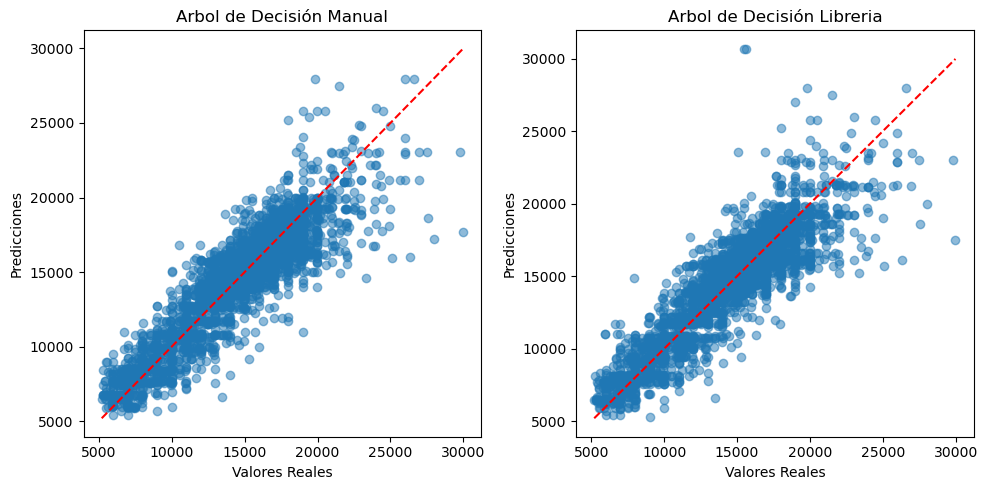

In [29]:
# Comparación gráfica de resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Predicciones Arbol Manual
plt.subplot(1, 2, 1)
plt.scatter(y_test, manual_tree_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Arbol de Decisión Manual")

# Predicciones Arbol MAE
plt.subplot(1, 2, 2)
plt.scatter(y_test, dt_reg_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Arbol de Decisión Libreria")

plt.tight_layout()
plt.show()

### Punto 1: **Análisis resultados**

En este punto se creó un árbol manualmente, haciendo uso de las funciones que se crearon en laboratorios pasados. Fue necesario codificar las variables boolenas de las muestras de entrenamiento y prueba a númericas para que las funciones trabajaran correctamente (particiones). <br>

El modelo se entrenó con los siguientes parámetros: min_gain=0.001, max_depth=10, num_pct=10, y estos fueron los resultados obtenidos en el conjunto de prueba: <br>

RMSE : $1692.10 <br>
MAE  :  $955.60 <br>

De manera muy general, si se comparan estos valores con el promedio del precio listado de los carros en el conjunto de prueba, $14600 estos errores parecen aceptables. 6.54% sería el error típico (MAE), mientras que ocasionalmente se pueden tener errores de hasta el 11.6% (RMSE)Como se observa graficamente, las predicciones parecen alejarse mas de la linea perfecta cuando los precios son mas altos. Este fenómeno se presenta aún antes en el modelo que se implenta usando libreria y por eso el RMSE es más alto en ese caso.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
# Utilizando libreria resample de sklearn

from sklearn.utils import resample

# Listas para modelos y predicciones
models= []

# predicciones modelos
preds = []

# Parametros
n_estimators = 10
max_depth_val = 10

In [44]:
# 10 Decision Trees - max_depth 10 para coincidir con arbol manual

from sklearn.tree import DecisionTreeRegressor

for _ in range(n_estimators):
    X_sample, y_sample = resample(X_train_enc, y_train, replace=True, random_state=42)
    model = DecisionTreeRegressor(max_depth=max_depth_val, random_state=42)
    model.fit(X_sample, y_sample)
    preds.append(model.predict(X_test_enc))
    models.append(model)

In [45]:
len(preds)

20

In [46]:
# Evaluación
def evaluate_ensemble(predictions, y_true):
     # Calculate the average prediction across all models
    ensemble_prediction = np.mean(predictions, axis=0)

    # Calculate regression metrics
    rmse = round(np.sqrt(mean_squared_error(y_true, ensemble_prediction)),1)
    mae = round(median_absolute_error(y_true, ensemble_prediction),1)

    return rmse, mae


In [47]:
rmse_treeBagging, mae_treeBagging = evaluate_ensemble(preds, y_test)
print("El RMSE del ensamble manual usando bagging de 10 árboles de decisión es:", f"{rmse_treeBagging:.3f}")
print("El MAE del ensamble manual usando bagging de 10 árboles de decisión es:", f"{mae_treeBagging:.3f}")

El RMSE del ensamble manual usando bagging de 10 árboles de decisión es: 1629.400
El MAE del ensamble manual usando bagging de 10 árboles de decisión es: 896.600


In [48]:
#Implementación según laboraorio manual de bagging de semana 1

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=42)

print("Primeros índices de X_train2:", X_train2.index[:5].tolist())
print("Primeros índices de y_train2:", y_train2.index[:5].tolist())
print("Primeros índices de X_test2:", X_test2.index[:5].tolist())
print("Primeros índices de y_test2:", y_test2.index[:5].tolist())

X_train_enc2 = encode_bool(X_train2)
X_test_enc2 = encode_bool(X_test2)

print("Primeros índices de X_train_enc2:", X_train_enc2.index[:5].tolist())
print("Primeros índices de y_train2:", y_train2.index[:5].tolist())
print("Primeros índices de X_test_enc2:", X_test_enc2.index[:5].tolist())
print("Primeros índices de y_test2:", y_test2.index[:5].tolist())

Primeros índices de X_train2: [318288, 333638, 234716, 208752, 348892]
Primeros índices de y_train2: [318288, 333638, 234716, 208752, 348892]
Primeros índices de X_test2: [257343, 326011, 242354, 266376, 396954]
Primeros índices de y_test2: [257343, 326011, 242354, 266376, 396954]
Primeros índices de X_train_enc2: [318288, 333638, 234716, 208752, 348892]
Primeros índices de y_train2: [318288, 333638, 234716, 208752, 348892]
Primeros índices de X_test_enc2: [257343, 326011, 242354, 266376, 396954]
Primeros índices de y_test2: [257343, 326011, 242354, 266376, 396954]


In [ ]:
# Se crea un arreglo del mismo tamaño del x train

np.random.seed(1)

obs_X = X_train_enc2.shape[0] # Conteo cantidad de observaciones

print(obs_X)
# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, obs_X)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=obs_X, replace=True))

7031
Arreglo: [   1    2    3 ... 7028 7029 7030]
Muestreo aleatorio:  [5158  236 3981 ... 5886 6316 1043]


In [50]:
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_B = 10

samples = [np.random.choice(a=obs_X, size=obs_X, replace=True) for _ in range(1, n_B +1 )]

#len(samples[0])

In [52]:
# Definición del modelo usando DecisionTreeRegressor de sklearn

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test_enc2.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    #print(i, sample)
    X_train_sample = X_train_enc2.iloc[sample]
    y_train_sample = y_train2.iloc[sample]
    model = DecisionTreeRegressor(max_depth=10, random_state=123)
    model.fit(X_train_sample, y_train_sample)
    y_pred.iloc[:,i] = model.predict(X_test_enc2)

y_pred

,0,1,2,3,4,5,6,7,8,9
257343,13121.938776,13522.636735,12646.0,13026.902256,13421.193548,11858.0,13690.653595,13308.290076,12644.851064,13358.168142
326011,6151.45098,6556.75,5954.0,6501.884615,5928.166667,7094.027027,6342.75,6512.0,6430.652174,6426.0
242354,16001.935484,16453.971631,16200.020408,16613.25,15966.0,15718.747423,15592.403846,16163.537815,16295.442478,16129.164062
266376,17655.252525,17993.206349,17383.375,18428.351351,17542.288462,18915.8,17497.10101,17737.433333,17054.27907,16938.944056
396954,16815.470588,17467.104167,17298.475,17546.540541,16607.0,17381.348837,17212.190476,17300.5,16913.95,17126.954545
...,...,...,...,...,...,...,...,...,...,...
144298,16072.727273,16254.66759,16309.09636,16041.051546,16296.380769,16142.615702,16151.554217,16034.768817,15957.21865,16193.936364
364521,17655.252525,15043.333333,16655.470588,17552.2,16445.818182,17007.520833,16151.554217,16904.202899,18022.12766,16193.936364
120072,19660.923077,18718.688889,18180.119048,18187.555556,18019.73913,18579.866667,18521.712389,18798.485714,19586.214286,18443.746032
99878,12221.142857,12915.833333,12926.0,13009.225806,12211.022222,12488.540816,12848.486111,12669.263158,12856.75,12203.285714


In [ ]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test2)))

Árbol  0 tiene un error:  1775.8563135051174
Árbol  1 tiene un error:  1739.395455995707
Árbol  2 tiene un error:  1808.5489184132953
Árbol  3 tiene un error:  1730.96480613849
Árbol  4 tiene un error:  1771.4862404728347
Árbol  5 tiene un error:  1756.5272756142854
Árbol  6 tiene un error:  1792.7041808022227
Árbol  7 tiene un error:  1833.5147009000593
Árbol  8 tiene un error:  1794.3581244002546
Árbol  9 tiene un error:  1778.246107270815


In [ ]:
# Error al promediar las predicciones de todos los árboles
print('RSME: ', round(np.sqrt(mean_squared_error(y_pred.mean(axis=1), y_test2)),3))
print("MAE :",round(median_absolute_error(y_pred.mean(axis=1),y_test2),3))

RSME:  1610.653
MAE : 899.568


### Punto 2: **Análisis resultados**

Para mantener la consistencia con el punto anterior se mantuvo la máxima profundidad de los arboles en 10. Y aunque no era necesario se utilizó la muestra codificada numericamente. También se hicieron dos implementaciones, una funcionalidad resample de la libreria utils y otras haciendodolo manualmente. 

Las métricas de rendimiento del modelo de bagging manual usando resample fueron:  
RMSE: $1629.40
MAE: $896.60 

Las métricas de rendimiento del modelo de bagging manual **sin usar**  resample fueron:  

RMSE: $1610.65
MAE: $899.56

Podemos ver que incluso siendo una baja cantidad de muestras y sin calibrar los parámetros ya se logra una mejora respecto al punto anterior (Arbol Manual). Esto pone en evidencia las ventajas de utilizar el método de bagging para obtener un mejor desempeño en los modelos.
La métrica Median Absolut Error nos permite interpretar facilmente la magnitud del error, en este caso considerando que el promedio de la variable precio en el conjunto de prueba es $14600, consideramos que tanto el error de $900 como el modelo son aceptables.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3

# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
from numpy import log
from sklearn.ensemble import BaggingRegressor

n_features = X_train_enc2.shape[1]


bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features=int(np.log2(n_features)),
                          bootstrap=True, oob_score=False, random_state=1)

bagreg.fit(X_train_enc2, y_train2)
preds2 = bagreg.predict(X_test_enc2)

print("El max_features es: ",int(np.log2(n_features)))

El max_features es:  3


In [58]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test

rmse2 = round(np.sqrt(mean_squared_error(y_test2, preds2)),1)
mae2 = round(median_absolute_error(y_test2, preds2),1)

print("El RMSE del ensamble usando bagging regresor de sklearn  es:", f"{rmse2:.3f}")
print("El MAE del ensamble usando bagging regresor de sklearn:", f"{mae2:.3f}")


El RMSE del ensamble usando bagging regresor de sklearn  es: 2013.400
El MAE del ensamble usando bagging regresor de sklearn: 1191.000


### Punto 3: **Análisis resultados**

Las métricas de rendimiento del modelo de bagging usando la librería de Bagging Regressor con max_features = log(n_features) fueron:  
RMSE: $2013.4 <br>
MAE: $1191.0  

En este punto se nos pide utilizar cómo parámetro un número máximo de variables y en este caso es 3. Con está elección el error es peor que cualquiera de los modelos anteriores, tanto en el RMSE cómo en el MAE lo que indica que este parámetro está limitando las posibilidades del modelo. En los puntos siguientes se experimentará con la calibración de modelos más robustos y podremos ver cuales son los parámetros óptimos para este problema.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Random Forest para regresión  y comenten sobre el desempeño del modelo.

In [84]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de regresión
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [79]:
# Prediccion Y Evaluación del Modelo
y_pred = model_rf.predict(X_test_enc)
rmse =np.sqrt(mean_squared_error(y_test, y_pred))
mae = median_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 1765.4118259983413
MAE: 1027.3100000000009


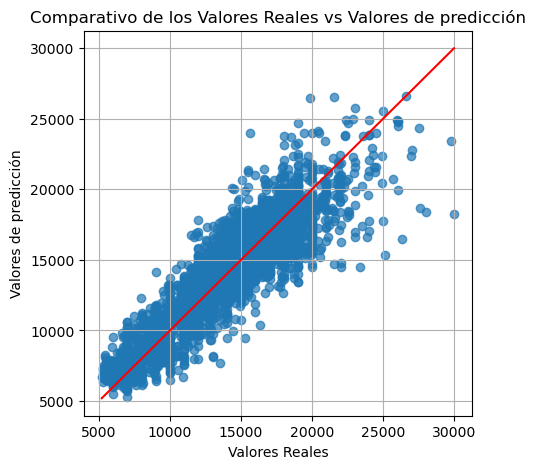

In [80]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reales')
plt.ylabel('Valores de predicción')
plt.title('Comparativo de los Valores Reales vs Valores de predicción')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.grid(True)
plt.show()

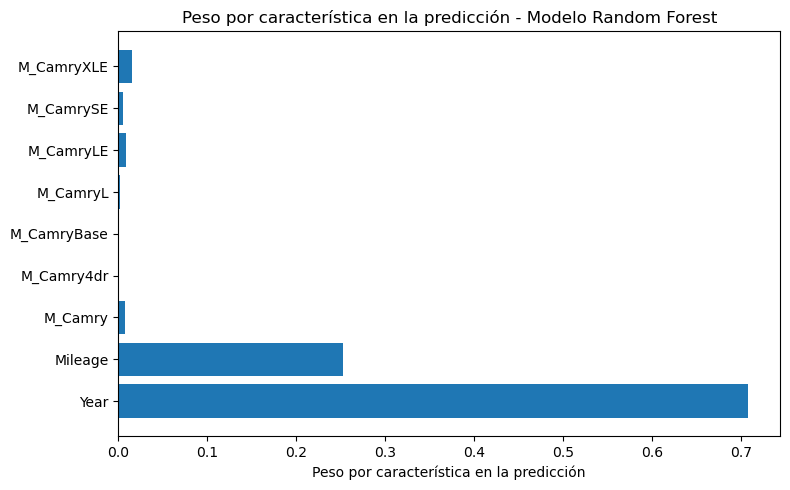

In [ ]:
# Visualización básica de la importancia de características
plt.figure(figsize=(8, 5))
plt.barh(X_train.columns, model_rf.feature_importances_)
plt.xlabel('Peso por característica en la predicción')
plt.title('Peso por característica en la predicción - Modelo Random Forest')
plt.tight_layout()
plt.show()

### Punto 4: **Análisis resultados**

En este punto se hizo el entrenamiento del modelo con sus parametros por defecto y se obtuvieron las siguientes métricas al evaluarlo sobre el conjunto de prueba: 

RMSE: $1765.41 <br>
MAE: $1027.31

Estas métricas dejan mucho que desear si se comparan con las obtenidas en los puntos anteriores. Solo el modelo de Bagging con limitación de max_features tuvo un desempeño peor. Esto nos indica que el modelo se beneficiará de la calibración de parámetros que se nos pide hacer de los parámetros. <br>

Finalmente, en este modelo se encuentra que las características más importantes son en su orden el año y el millaje del vehículo. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Random Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

**Antes de hacer la calibración de los parametros se hará una validación cruzada sobre X_train con el modelo sin calibrar para poder hacer una comparación antes y despues de la calibración**. 

##### Validación Cruzada Modelo Sin Calibración de Parámetros. 



In [86]:
rmse_scores = pd.Series(-cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))
print(pd.Series(rmse_scores).describe())

count       5.000000
mean     1737.517934
std        60.711034
min      1657.996310
25%      1695.009933
50%      1756.550851
75%      1767.264430
max      1810.768148
dtype: float64


In [125]:
#MAE
mae_scores = -cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(pd.Series(mae_scores).describe())

count       5.000000
mean     1298.862487
std        37.678806
min      1254.485327
25%      1275.361755
50%      1291.317236
75%      1325.262628
max      1347.885489
dtype: float64


Las métricas obtenidas de la validación cruzada con el scoring fijado en el valor negativo del RMSE nos indican que el modelo es relativamente estable,  con una desviación estandar del error 60.71 pequeña comparada con el promedio obtenido: **1737.51** Por su parte las métricas obtenidas con el socring fiajdo en el valor negativo del MAE tambiên son aun más estables con un promedio de **1298.86** y una desviación estandar de 37.67

No se ahondará en el análisis de estas métricas dado que solo utilizaremos el promedio del **RMSE = 1737.51** y del **MAE = 1298.86** como referencia para comparar los resultados obtenidos con la calibración en los siguientes pasos.

##### Calibración max_depth

**max_depth** es la profundidad que se debe considerar en cada árbol.

In [105]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(5, 20,5)

# Definición de lista para almacenar la exactitud (rmse) promedio para cada valor de max_depth
rmse_max_depth_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    Rgr = RandomForestRegressor(max_depth=depth, random_state=1, n_jobs=-1)
    rmse_max_depth_scores.append(-(cross_val_score(Rgr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()))

In [106]:
# Mejor RMSE
best_index = np.argmin(rmse_max_depth_scores)
best_max_depth = depth_range[best_index]
best_rmse = rmse_max_depth_scores[best_index]

print(f"Mejor parámetro max_depth: {best_max_depth}")
print(f"Mejor RMSE: {best_rmse:.4f}")

Mejor parámetro max_depth: 10
Mejor RMSE: 1554.9323


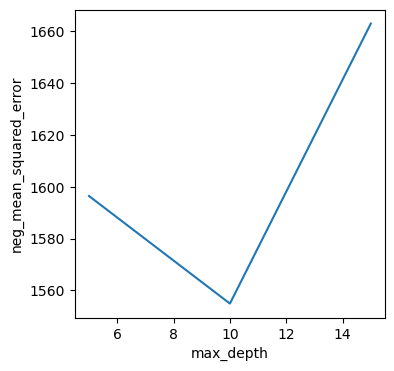

In [107]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.figure(figsize=(4, 4))
plt.plot(depth_range, rmse_max_depth_scores)
plt.xlabel('max_depth')
plt.ylabel('neg_mean_squared_error')
plt.show()

##### Calibración max_features

**max_features** es el número de variables que se deben considerar en cada árbol.

In [108]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1] + 1)

# Definición de lista para almacenar la exactitud (mse) promedio para cada valor de max_features
rmse_max_features_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    Rgr = RandomForestRegressor(max_depth=10, max_features = feature, random_state=1, n_jobs=-1)
    rmse_max_features_scores.append(-(cross_val_score(Rgr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()))

In [109]:
# Mejor RMSE
best_index = np.argmin(rmse_max_features_scores)
best_max_features = feature_range[best_index]
best_rmse = rmse_max_features_scores[best_index]

print(f"Mejor parámetro max_features: {best_max_features}")
print(f"Mejor RMSE: {best_rmse:.4f}")

Mejor parámetro max_features: 2
Mejor RMSE: 1533.5619


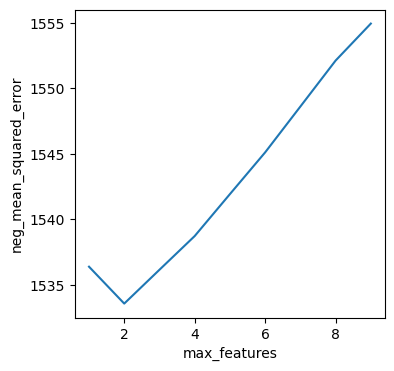

In [110]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.figure(figsize=(4, 4))
plt.plot(feature_range, rmse_max_features_scores)
plt.xlabel('max_features')
plt.ylabel('neg_mean_squared_error')
plt.show()

##### Calibración de n_estimators

**n_estimators** es la cantidad de árboles a contruir dentro del bosque aleatorio.

In [111]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (mse) promedio para cada valor de n_estimators
rmse_n_estimators_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    Rgr = RandomForestRegressor(n_estimators=estimator, max_features=2, max_depth=10, random_state=1, n_jobs=-1)
    rmse_n_estimators_scores.append(-(cross_val_score(Rgr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()))

In [112]:
# Mejor RMSE
best_index = np.argmin(rmse_n_estimators_scores)
best_n_estimators = estimator_range[best_index]
best_rmse = rmse_n_estimators_scores[best_index]

print(f"Mejor parámetro n_estimators: {best_n_estimators}")
print(f"Mejor RMSE: {best_rmse:.4f}")

Mejor parámetro n_estimators: 120
Mejor RMSE: 1533.3295


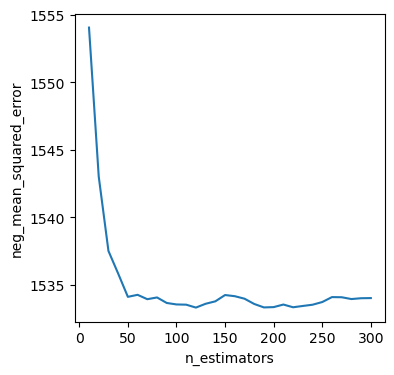

In [114]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.figure(figsize=(4, 4))
plt.plot(estimator_range, rmse_n_estimators_scores)
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_squared_error')
plt.show()

In [115]:
# Definición del modelo con los parámetros encontrados
modelo_rf_calibrado = RandomForestRegressor(max_depth=10, max_features = 2, n_estimators=120, random_state=1, n_jobs=-1)
modelo_rf_calibrado.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, max_features=2, n_estimators=120, n_jobs=-1,
                      random_state=1)

In [116]:
# Predicción y Evaluación
y_cal_pred = modelo_rf_calibrado.predict(X_test)
modelo_rf_calibrado_rmse = np.sqrt(mean_squared_error(y_test, y_cal_pred))
modelo_rf_calibrado_mae = median_absolute_error(y_test, y_cal_pred)
print("El RMSE RF calibrado es:", f"{modelo_rf_calibrado_rmse:}")
print("El MAE RF calibrado es:", f"{modelo_rf_calibrado_mae:}")


El RMSE RF calibrado es: 1563.1001850215762
El MAE RF calibrado es: 870.96065070032


In [121]:
# Impresión de resultados de desempeño del modelo
feature_cols = X.columns
pd.DataFrame({'feature':feature_cols, 'importance':modelo_rf_calibrado.feature_importances_}).sort_values('importance')

,feature,importance
5,M_CamryL,0.004265
4,M_CamryBase,0.006010
6,M_CamryLE,0.006769
2,M_Camry,0.008412
8,M_CamryXLE,0.020708
7,M_CamrySE,0.028414
3,M_Camry4dr,0.109644
1,Mileage,0.402559
0,Year,0.413218


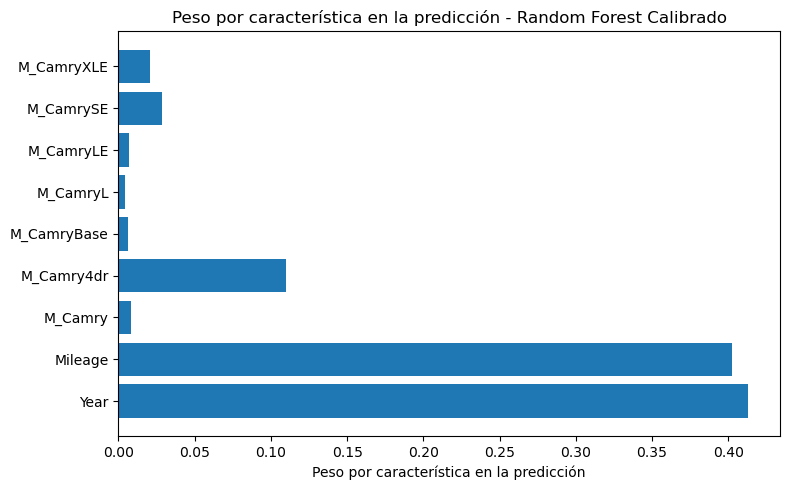

In [122]:
# Visualización básica de la importancia de características
plt.figure(figsize=(8, 5))
plt.barh(X.columns, modelo_rf_calibrado.feature_importances_)
plt.xlabel('Peso por característica en la predicción')
plt.title('Peso por característica en la predicción - Random Forest Calibrado')
plt.tight_layout()
plt.show()

### Punto 5: **Análisis resultados**

En este punto se realiza una validación cruzada sobre la muestra de entrenamiento (X_train) con el modelo de Random Forest utilizando sus valores por defecto. Luego se calibran los parámetros solicitados en el ejercicio en su orden de manera secuencial. <br>

Resultados Iniciales sin calibrar el Modelo  <br>
RMSE: 1737.51<br>
MAE : 1298.86 <br> 

A continuación se observa la evolución en la mejora de las métricas a medida que se calibran los diferentes parámetros:<br>

1. max_depth=10,  RMSE: 1554.9323 con esta primera calibración se observa la mejora más importante <br>

2. max_features=2, RMSE: 1533.56 con la calibración del max_features y tomando el max_depth=10, el desempeño del modelo mejora un poco mas <br>

3. n_estimators :120, RMSE: 1533.33, finalmente, con la calibración del n_estimators se concluye que el mejor RSME se obtiene con 120 arboles, aumentar el numero de arboles puede mejorar pero no es significativo. <br>

Con estos parametros se entrena un modelo final y se obtienen los siguientes resultados sobre el conjunto de prueba: <br>

RMSE: 1563.10 <br>
MAE : 870.96 <br>

Estos valores se compararán con los valores obtenidos con el modelo XGBoost en la siguiente sección. 

**Comparando los resultados antes y despues de la calibración se evidencia una mejora en el desempeño al reducirse ambas métricas considerablemente**

Influencia de Variables: Las variables mas importantes son: 
Mileage (Millaje) tiene una influencia de 0.402559 (40%)
Year (Año) tiene una influencia de 0.413218 (41%)

Entre estas dos variables tienen una relevancia del 81% lo que nos lleva a concluir que el precio del vehiculo depende del año y del millaje.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [126]:
# Celda 6
# NOTA: El punto 6 se ha distribuido en varias celdas para facilitar la ejecución y visualización de resultados:

# 1) Instalación de XGBoost e importación de librerías
# 2) Creación, entrenamiento y evaluación del modelo XGBoost para regresión
# 3) Peso por cada características (feature: año, millaje y modelo) en la predicción
# 4) Análisis de resultados

# Instalación de XGBoost
# Se llevó a cabo la instalación de XGBoost la primera vez.
# !pip install xgboost

# Importación de librerías necesarias
# La diferencia con el laboratorio 2 de la semana 2 es que en el laboratorio 2 se busca predecir el abandono de clientes (Churn),
# la cual es una variable categórica, mientras que aquí estamos hablando de predecir el precio de automóviles, es decir, de una 
# variable continua, y por tanto no es un problema de clasificación, sino de regresión.
# Por ello, se ha utilizado XGBRegressor. De igual manera,en lugar de utilizar las métricas de evaluación son F1-Score y Accuracy,
# que son apropiadas para clasificación, aquí se van a utilizar RMSE (Root Mean Squared Error) y MAE (Mean Absolute Error).

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [127]:
# Creación del modelo XGBoost para regresión con parámetros por defecto
# Se utiliza "objective='reg:squarederror'" para hacer la regresión usando el error cuadrático como función objetivo

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Entrenamiento del modelo
xgb_reg.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = xgb_reg.predict(X_test)

# Evaluación del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Métricas de rendimiento del modelo XGBoost:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")

Métricas de rendimiento del modelo XGBoost:
RMSE: $1605.24
MAE: $1185.23


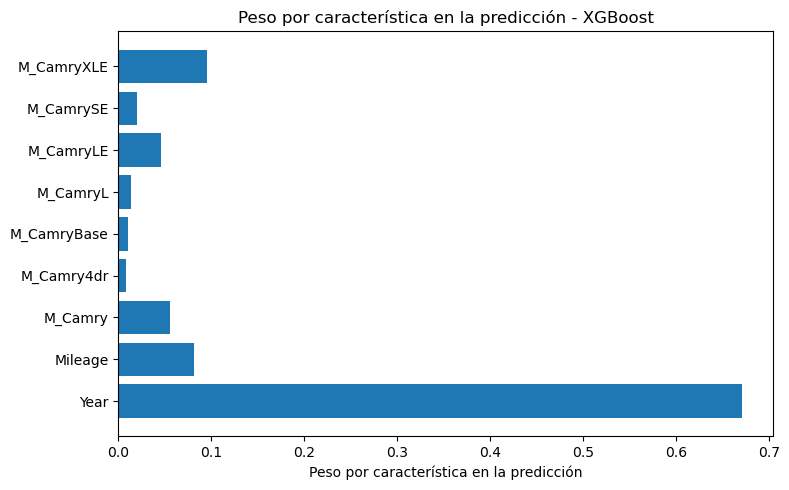

In [128]:
# Visualización básica de la importancia de características
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(X.columns, xgb_reg.feature_importances_)
plt.xlabel('Peso por característica en la predicción')
plt.title('Peso por característica en la predicción - XGBoost')
plt.tight_layout()
plt.show()

### Punto 6: **Análisis resultados**

Las métricas de rendimiento del modelo XGBoost fueron: <br>
RMSE: $1605.24 <br>
MAE: $1185.23  <br>

Estos resultados presentan uan mejora importante sobre los que se obtuvieron al entrenar el modelo Random Forest con sus parámetrso también por defecto: (RMSE: $1765.41, MAE: $1027.31)

Respecto a la gráfica de "Peso por característica (feature) en la predicción, el mayor peso lo obtuvo el año del automóvil (alrededor del 67%), seguido del modelo Camry XLE (alrededor del 10%) y del millaje (alrededor del 9%).

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros encontrados:
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05}

Métricas del modelo XGBoost calibrado:
RMSE: $1545.00
MAE: $1133.37

Mejora respecto al modelo base:
RMSE: $60.24 de mejora
MAE: $51.86 de mejora


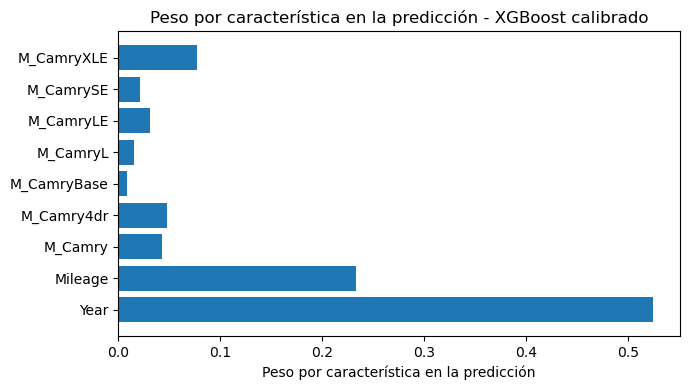

In [ ]:
# Celda 7
# NOTA: El punto 7 se ha distribuido en varias celdas para facilitar la ejecución y visualización de resultados:

# 1) Importación de la librería GridSearchCV, definión del grid, entrenamiento del modelo y visualización de resultados.
# 2) Análisis resultados XGBoost con calibración de parámetros con el comparativo VS el punto 6
# 3) Análisis del comportamiento de RMSE y MAE para diferentes precios reales VS predichos
# 4) Análisis de la gráfica

# Punto 7 - Calibración de parámetros XGBoost
from sklearn.model_selection import GridSearchCV

# Se define el modelo base
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Se define el grid de parámetros a probar
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'gamma': [0, 0.1, 0.5, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Configuramos la búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Se ejecuta la búsqueda de parámetros
grid_search.fit(X_train, y_train)

# Se muestran los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Se evalua el rendimiento del mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Métricas de rendimiento
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nMétricas del modelo XGBoost calibrado:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")

# Comparación con el modelo base
print(f"\nMejora respecto al modelo base:")
print(f"RMSE: ${1605.24 - rmse:.2f} de mejora")
print(f"MAE: ${1185.23 - mae:.2f} de mejora")

# Visualizamos la importancia de características del modelo calibrado
plt.figure(figsize=(7, 4))
plt.barh(X.columns, best_model.feature_importances_)
plt.xlabel('Peso por característica en la predicción')
plt.title('Peso por característica en la predicción - XGBoost calibrado')
plt.tight_layout()
plt.show()

### Punto 7: **Análisis resultados**

Después de calibrar parámetros los resultados fueron:

Fitting 5 folds for each of 48 candidates, totalling 240 fits. Validación cruzada de 5 pliegues, donde las combinaciones de parámetros que se tuvieron en cuenta fueron:  

    'learning_rate': [0.01, 0.05, 0.1, 0.3], (4 opciones)  
    'gamma': [0, 0.1, 0.5, 1.0], (4 opciones)  
    'colsample_bytree': [0.5, 0.7, 1.0], (3 opciones)  
    Total combinaciones: 4 x 4 x 3 = 48 por 5 iteraciones por la validación cruzada.

Mejores parámetros encontrados:
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05}

learning_rate (0.05): Parámetro que controla cuánto contribuye cada árbol al modelo final. El valor óptimo encontrado (0.05) es menor que el valor predeterminado (0.3). Esto indica que un enfoque más conservador funciona mejor para este problema. Un learning_rate más bajo reduce el riesgo de sobreajuste al permitir que el modelo aprenda más gradualmente, a costa de requerir más árboles para alcanzar un rendimiento similar.  

gamma (0): Este parámetro controla la poda mínima requerida para hacer una partición adicional en un nodo de árbol. El valor óptimo de 0 indica que no se necesita una ganancia mínima para crear nuevas divisiones. Nota: se hicieron pruebas con diferentes "escalas" de valores de gamma (por ejemplo, [50, 100, 200 y 500] y luego con [1000, 5000, 10000, 50000]) y no hubo ningún cambio, lo que puede sugerir que para este problema específico, la regularización a través de gamma no es tan crítica como otros parámetros.

colsample_bytree (0.7): Este parámetro determina la fracción de características que se consideran para cada árbol. El valor óptimo de 0.7 significa que cada árbol utiliza aleatoriamente el 70% de las características disponibles. Este valor menor que 1 introduce diversidad entre los árboles, mejorando la generalización del modelo.

Métricas del modelo XGBoost calibrado:<br>
RMSE: $1545.00<br>
MAE: $1133.37<br>

Mejora respecto al modelo base:
RMSE: $60.24 de mejora<br>
MAE: $51.86 de mejora<br>

Respecto a la gráfica de "Peso por característica (feature) en la predicción, hubo un cambio en la distribución de los pesos, respecto al modelo sin  calibración de parámetros. En este caso, el mayor peso lo maantuvo el año del automóvil (bajó del 67% al 65%), seguido ahora del millaje (pasó del 9% al 18%) y luego el modelo Camry XLE (bajó del 10% a alrededor del 6%).

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

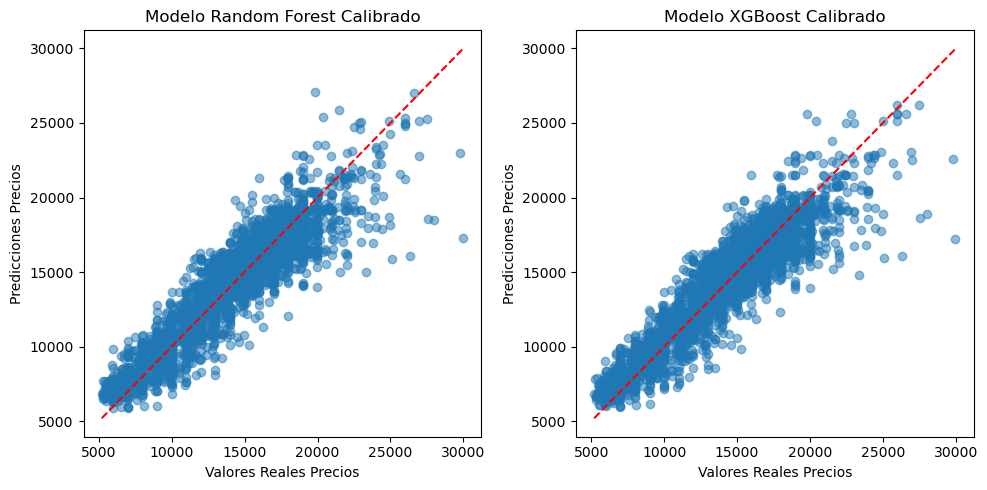

In [130]:
# Celda 8
# Comparación gráfica de resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Predicciones Random Forest Calibrado
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_cal_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales Precios")
plt.ylabel("Predicciones Precios")
plt.title("Modelo Random Forest Calibrado")

# Predicciones XGBoost Calibrado
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales Precios")
plt.ylabel("Predicciones Precios")
plt.title("Modelo XGBoost Calibrado")

plt.tight_layout()
plt.show()

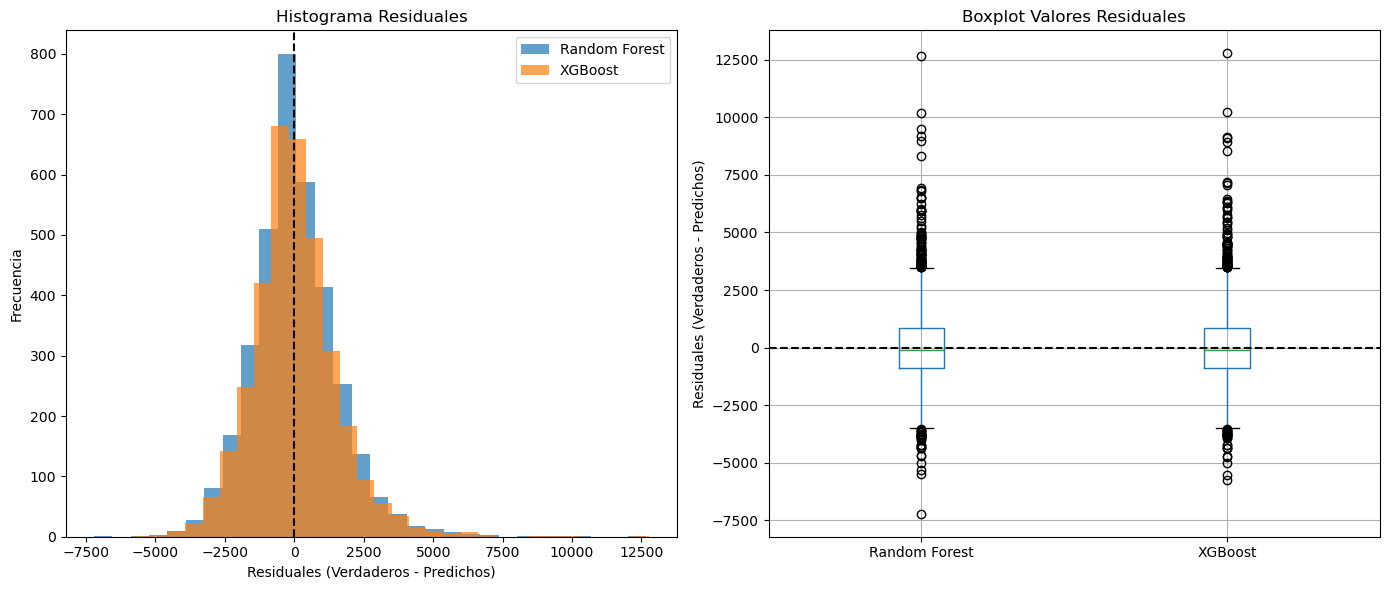

In [133]:
# Valores Residuales
residuals_rf = y_test - y_cal_pred
residuals_xgb = y_test - y_pred
residuals_df = pd.DataFrame({
    'Random Forest': residuals_rf,
    'XGBoost': residuals_xgb
})

# histograms
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.hist(residuals_rf, bins=30, alpha=0.7, label='Random Forest')
plt.hist(residuals_xgb, bins=30, alpha=0.7, label='XGBoost')
plt.axvline(0, color='black', linestyle='--')
plt.title('Histograma Residuales')
plt.xlabel('Residuales (Verdaderos - Predichos)')
plt.ylabel('Frecuencia')
plt.legend()

# Plot boxplots
plt.subplot(1, 2, 2)
residuals_df.boxplot()
plt.title('Boxplot Valores Residuales')
plt.ylabel('Residuales (Verdaderos - Predichos)')
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

### Punto 8: **Análisis resultados**

El comportamiento observado en las gráficas anteriores es muy similar. En ambos casos se observa que los modelos tienen mayor dificultad prediciendo valores altos de los precios de los carros. En ambos casos los valores residuales estan centrados alrededor de cero, pero presentan valores atipicos. <br>

Las métricas obtenidas en el conjunto de prueba con los modelos calibrados son las siguientes: <br>

**Modelo Random Forest Calibrado**<br>
RMSE: 1563.10 <br>
MAE : 870.96 <br>

**Modelo XGBoost calibrado:**<br>
RMSE: $1545.00<br>
MAE: $1133.37<br>

Estos resultados hacen dificil sacar las conclusiones dado que por un lado el modelo Random forest tiene un mejor comportamiento en cuanto al MAE 870.93 vs 1133.37, y de otro lado el modelo XGBoost tiene un mejor comportamiento en cuanto al RMSE. Sin embargo la diferencia no es tan significativa. Entonces la elección final del modelo dependería de que nos importa más: 

Si el objetivo es tener predicciones típicamente más precisas (es decir, menor error promedio), el modelo Random Forest es superior, Si el objetivo fuera reducir el impacto de errores grandes extremos, XGBoost tendría una ligera ventaja en este aspecto por su mejor manejo de valores anómalos (outliers) ver abajo. sin emabrgo, dado que el MAE suele ser más intuitivo y relevante y facil de explicar porque representa un “error típico” que la mayoría de las predicciones tendrán creemos que el Random Forest es el mejor modelo en este caso. Adicionamente tiene la ventaja de que es un modelo menos complejo y por tanto más facil de explicar a un público no experto. En tanto que el XGBoost es más dificil de explicar y entender. 

Adicionalmente, es importante mencionar que utilizamos dos tecnicas distintas de calibración, y con la secuencial en el Random Forest pudimos excluir combinaciones que dieran aun mejores resultados, pero quisimos explorar la técnica de gridsearch en el punto 8. Finalmente en el ultimo punto incluimos una gráfica que muestra la robustez del modelo XGBoost frente a los valores atípicos. 


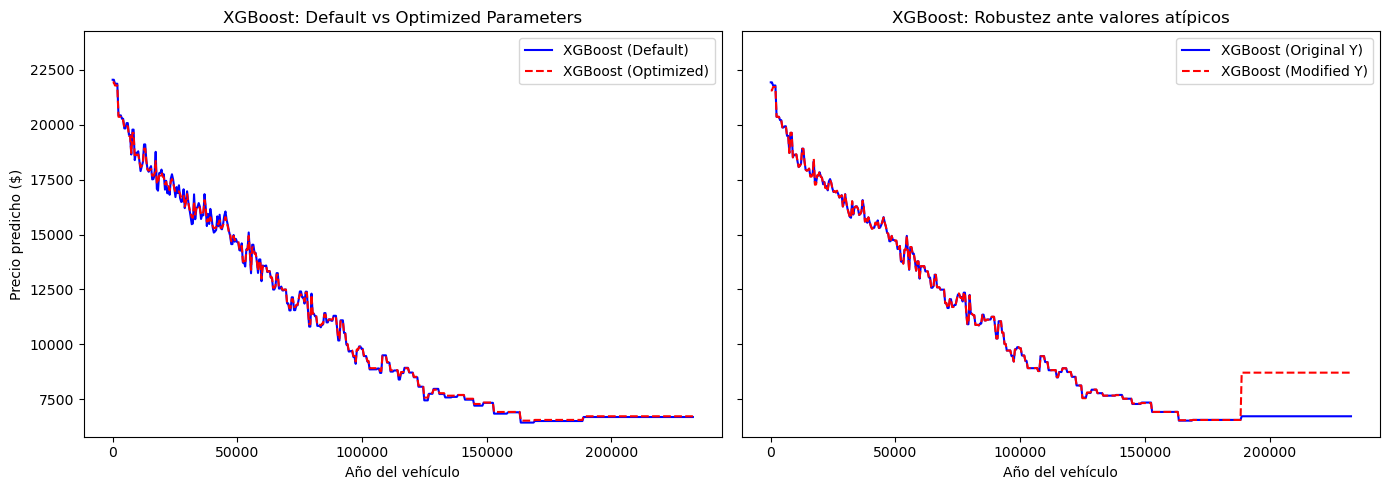

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Usamos los datos de tu taller
# Seleccionamos el año como característica principal para visualización
# X_feature = X_train['Year'].values.reshape(-1, 1)
X_feature = X_train['Mileage'].values.reshape(-1, 1)
y = y_train.values

# Introducir algunos valores extremos para demostrar robustez (opcional)
y_modified = y.copy()
y_modified[np.argmax(X_feature)] = y.max() * 2  # Duplicamos el valor máximo
y_modified[np.argmin(X_feature)] = y.min() * 0.5  # Reducimos el valor mínimo

# Entrenamos modelos XGBoost con diferentes configuraciones
# Modelo con parámetros por defecto
xgb_default = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_default.fit(X_feature, y)

# Modelo con los mejores parámetros encontrados
xgb_optimized = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.7,
    random_state=42
)
xgb_optimized.fit(X_feature, y)

# Modelo con datos modificados (para mostrar robustez)
xgb_modified = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.7,
    random_state=42
)
xgb_modified.fit(X_feature, y_modified)

# Generar predicciones
X_test = np.linspace(X_feature.min(), X_feature.max(), 500).reshape(-1, 1)
y_pred_default = xgb_default.predict(X_test)
y_pred_optimized = xgb_optimized.predict(X_test)
y_pred_modified = xgb_modified.predict(X_test)

# Configurar el rango del eje Y
y_min = min(y_pred_default.min(), y_pred_optimized.min()) * 0.9
y_max = max(y_pred_default.max(), y_pred_optimized.max()) * 1.1

# Crear gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# XGBoost por defecto vs optimizado
axs[0].plot(X_test, y_pred_default, color='blue', label="XGBoost (Default)")
axs[0].plot(X_test, y_pred_optimized, color='red', linestyle='dashed', label="XGBoost (Optimized)")
axs[0].set_title("XGBoost: Default vs Optimized Parameters")
axs[0].set_xlabel("Año del vehículo")
axs[0].set_ylabel("Precio predicho ($)")
axs[0].set_ylim(y_min, y_max)
axs[0].legend()

# XGBoost con datos originales vs modificados
axs[1].plot(X_test, y_pred_optimized, color='blue', label="XGBoost (Original Y)")
axs[1].plot(X_test, y_pred_modified, color='red', linestyle='dashed', label="XGBoost (Modified Y)")
axs[1].set_title("XGBoost: Robustez ante valores atípicos")
axs[1].set_xlabel("Año del vehículo")
axs[1].set_ylim(y_min, y_max)
axs[1].legend()

plt.tight_layout()
plt.show()